### (PSL) Coding Assignment 1

## Background

This assignment is related to the simulation study described in Section 2.3.1 (the so-called Scenario 2 or Example 2) of "Elements of Statistical Learning" (ESL).

## Scenario 2

The two-dimensional data $X \in R^2$ in each class are generated from a mixture of 10 different bivariate Gaussian distributions with uncorrelated components and different means, i.e.,

$$X | Y = k, Z = j \sim \mathcal{N}(\mathbf{m}_{kj}, s^2 I_2)$$

where $k = 0, 1,$ and $j = 1, 2, \ldots, 10$. Set

$$P(Y = k) = 1/2, \quad P(Z = j) = 1/10, \quad s^2 = 1/5.$$

In other words, given $Y = k$, $X$ follows a mixture distribution with probability density function (PDF)

$$\frac{1}{10} \sum_{j=1}^{10} \left(\frac{1}{\sqrt{2\pi s^2}}\right)^2 e^{-\|\mathbf{x}-\mathbf{m}_{kj}\|^2/(2s^2)}.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Part 1: Generate Data
Generate the 20 centers, 10 for each group.

In [2]:
csize = 10      
p = 2      
s = 1;      # sd for generating the centers within each class                    
m1 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[0, 1]] * csize)])

In [3]:
# 20 centers from two-dimensional normal distribution
# 10 for each group (2 classes)
print(m1)
print(m0)

[[ 0.41779536  0.69758344]
 [ 0.90010608 -0.97556581]
 [ 0.01866057 -0.73006385]
 [ 1.23213276 -0.12396337]
 [ 2.47099544  0.82639044]
 [ 0.93285702 -2.13765023]
 [ 1.95103631  0.575575  ]
 [ 2.79938286 -0.76425265]
 [ 0.81505129  1.19397443]
 [ 1.12715268 -0.66719251]]
[[ 0.09326533 -1.04269911]
 [ 0.54254745  1.99219913]
 [ 0.53447801  0.65469411]
 [-0.47742872 -0.42885063]
 [-0.10872086  2.43646925]
 [-1.98561481  1.10160654]
 [-1.2965501   0.43037902]
 [-0.70170271  1.39672631]
 [ 0.03182507  1.95038011]
 [ 1.29729813  1.47327445]]


In [4]:
# sd for generating both training and test data   
s = np.sqrt(float(1)/5) 

# Gerernating training data
# Randomly allocate the n samples for class 1 to the 10 clusters
n_train = 100
id1_train = np.random.randint(csize, size = n_train)
id0_train = np.random.randint(csize, size = n_train)

# Generate the training data
traindata = np.random.normal(size = (2 * n_train, p)) * s \
            + np.concatenate([m1[id1_train,:], m0[id0_train,:]])
ytrain = np.concatenate(([1]*n_train, [0]*n_train))

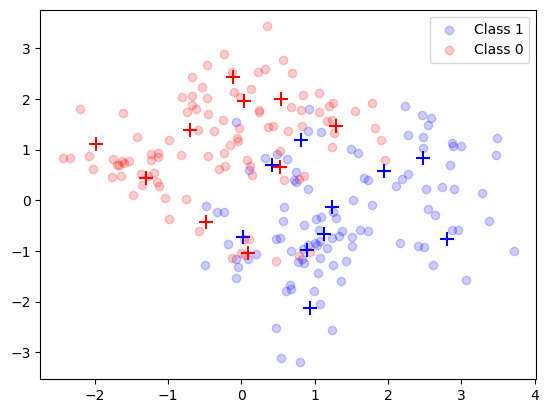

In [5]:
## Visualize the training data
plt.scatter(traindata[:n_train, 0], traindata[:n_train, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(traindata[n_train:, 0], traindata[n_train:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()

In [6]:
# Generate the test data
n_test = 5000
id1_test = np.random.randint(csize, size = n_test)
id0_test = np.random.randint(csize, size = n_test)

# Generate the test data
testdata = np.random.normal(size = (2 * n_test, p)) * s \
            + np.concatenate([m1[id1_test,:], m0[id0_test,:]])
ytest = np.concatenate(([1]*n_test, [0]*n_test))

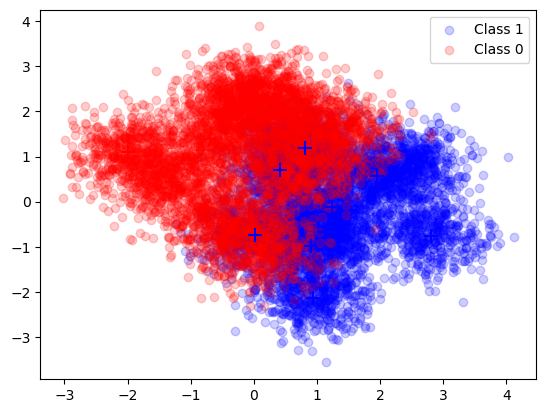

In [7]:
# Visualize the test data (optional)
plt.scatter(testdata[:n_test, 0], testdata[:n_test, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(testdata[n_test:, 0], testdata[n_test:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()

### Part 2: kNN

In [8]:
import numpy as np
from collections import Counter

# Function to calculate Euclidean distance
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

# kNN implementation
class kNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        # Compute distances between each test point and all training points
        distances = np.array([euclidean_distance(x, self.X_train) for x in X])
        # Get the indices of the k nearest neighbors
        k_indices = np.argsort(distances, axis=1)[:, :self.k]
        # Extract the labels of the k nearest neighbors
        k_nearest_labels = self.y_train[k_indices]
        # Determine the most common class label among the k neighbors
        return np.array([self._handle_ties(labels) for labels in k_nearest_labels])

    def _handle_ties(self, k_nearest_labels):
        class_counts = Counter(k_nearest_labels)
        most_common = class_counts.most_common()
        # Handle voting ties
        if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
            return np.random.choice([label for label, count in most_common])
        return most_common[0][0]

In [12]:
# using id1_train and id0_train to generate the training data
X_train = traindata
y_train = ytrain
# using id1_test and id0_test to generate the test data
X_test = testdata
y_test = ytest

# Test the kNN implementation
num_folds = [1, 3, 5]
results = {}
for k in num_folds:
    knn = kNN(k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    results[k] = y_pred


In [13]:
# confusion matrix
from sklearn.metrics import confusion_matrix

# Compute and print confusion matrices for each k value
for k in num_folds:
    y_pred = results[k]
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for k={k} (custom kNN):")
    print(cm)
    print()


Confusion Matrix for k=1:
[[4017  983]
 [1126 3874]]

Confusion Matrix for k=3:
[[3964 1036]
 [ 976 4024]]

Confusion Matrix for k=5:
[[3914 1086]
 [ 820 4180]]



In [15]:
# compare this with sklearn.neighbors.KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

for k in num_folds:
    knn_sklearn = KNeighborsClassifier(n_neighbors=k)
    knn_sklearn.fit(X_train, y_train)
    y_pred_sklearn = knn_sklearn.predict(X_test)
    cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
    print(f"Confusion Matrix for k={k} (sklearn):")
    print(cm_sklearn)
    print()

Confusion Matrix for k=1 (sklearn):
[[4017  983]
 [1126 3874]]

Confusion Matrix for k=3 (sklearn):
[[3964 1036]
 [ 976 4024]]

Confusion Matrix for k=5 (sklearn):
[[3914 1086]
 [ 820 4180]]

